### (Optional) Install Neural A* on Colab

We highly recommend the use of GPUs for faster training/planning.

In [ ]:
!git clone https://github.com/omron-sinicx/neural-astar

In [ ]:
%cd neural-astar
!pip install .

## Run Neural A*

In [5]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from neural_astar.planner import NeuralAstar, VanillaAstar
from neural_astar.utils.data import create_dataloader
from neural_astar.utils.training import set_global_seeds, calc_metrics_from_multiple_results, visualize_results

device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
neural_astar = NeuralAstar(encoder_arch='CNN').to(device)
neural_astar.load_state_dict(torch.load("data/cnn_mazes.pt", map_location=torch.device(device)))

vanilla_astar = VanillaAstar().to(device)

In [7]:
# average performances over 5 starts

set_global_seeds(1234)
dataloader = create_dataloader("data/mazes_032_moore_c8.npz", "test", 100, shuffle=False, num_starts=5)
va_outputs_list, na_outputs_list = [], []
with torch.no_grad():
    for map_designs, start_maps, goal_maps, opt_trajs in dataloader:
        for i in tqdm(range(start_maps.shape[1])):
            vanilla_astar.eval()
            va_outputs_list.append(vanilla_astar(map_designs.to(device), start_maps[:, i:i+1].to(device), goal_maps.to(device)))
            neural_astar.eval()
            na_outputs_list.append(neural_astar(map_designs.to(device), start_maps[:, i:i+1].to(device), goal_maps.to(device)))
            
calc_metrics_from_multiple_results(na_outputs_list, va_outputs_list)

Number of Test Samples: 100
	Size: 32x32


  0%|          | 0/5 [00:00<?, ?it/s]/u/pstone/agents6/haresh/Projects/miniconda3/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 5/5 [01:05<00:00, 13.20s/it]


optimality: 0.782, efficiency: 0.431, h_mean: 0.501

Number of Test Samples: 100
	Size: 32x32


(-0.5, 171.5, 35.5, -0.5)

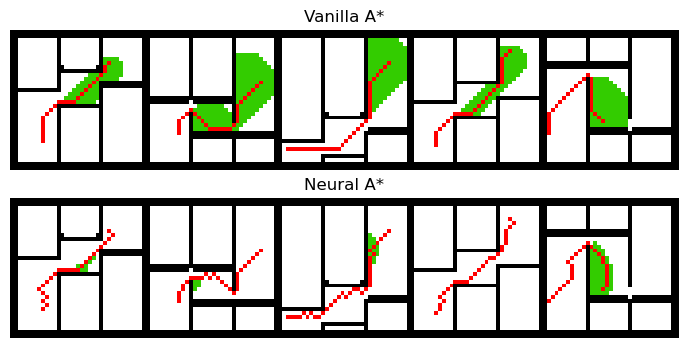

In [8]:
# Visualization

dataloader = create_dataloader("data/mazes_032_moore_c8.npz", "test", 5, shuffle=False, num_starts=1)
map_designs, start_maps, goal_maps, opt_trajs = next(iter(dataloader))
na_outputs = neural_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
va_outputs = vanilla_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))

plt.figure(figsize=[12, 4])
plt.subplot(2, 1, 1)
plt.imshow(visualize_results(map_designs, va_outputs))
plt.title("Vanilla A*")
plt.axis("off")
plt.subplot(2, 1, 2)
plt.imshow(visualize_results(map_designs, na_outputs))
plt.title("Neural A*")
plt.axis("off")


In [11]:
# Create gif animation

import moviepy.editor as mpy
from PIL import Image

instance_id = 1

na_outputs = neural_astar(map_designs[instance_id:instance_id + 1].to(device), 
                          start_maps[instance_id:instance_id + 1].to(device), 
                          goal_maps[instance_id:instance_id + 1].to(device), store_intermediate_results=True)
frames = [visualize_results(map_designs[instance_id:instance_id + 1], intermediate_results, scale=4) for intermediate_results in na_outputs.intermediate_results]
clip = mpy.ImageSequenceClip(frames + [frames[-1]] * 15, fps=30)
clip.write_gif("neural_astar.gif")


va_outputs = vanilla_astar(map_designs[instance_id:instance_id + 1].to(device), 
                          start_maps[instance_id:instance_id + 1].to(device), 
                          goal_maps[instance_id:instance_id + 1].to(device), store_intermediate_results=True)
frames = [visualize_results(map_designs[instance_id:instance_id + 1], intermediate_results, scale=4) for intermediate_results in va_outputs.intermediate_results]
clip = mpy.ImageSequenceClip(frames + [frames[-1]] * 15, fps=30)
clip.write_gif("astar.gif")

MoviePy - Building file neural_astar.gif with imageio.


MoviePy - Building file astar.gif with imageio.


## Train Neural A*

In [12]:
# CNN encoder
!python train.py

Number of Train Samples: 800
	Size: 32x32
Number of Validation Samples: 100
	Size: 32x32
Number of Test Samples: 100
	Size: 32x32
training:   0%|                       | 0/8 [00:00<?, ?it/s]/u/pstone/agents6/haresh/Projects/miniconda3/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
validation: 100%|█████████████| 1/1 [00:06<00:00,  6.15s/it]
[epoch:000] train_loss:7.94e-02, val_loss:9.70e-02,  optimality: 0.520, efficiency: 0.346, h_mean: 0.415
best score updated: -1.000 -> 0.415
validation: 100%|█████████████| 1/1 [00:05<00:00,  5.14s/it]
[epoch:001] train_loss:7.22e-02, val_loss:8.94e-02,  optimality: 0.560, efficiency: 0.389, h_mean: 0.459
best score updated: 0.415 -> 0.459
validation: 100%